In [1]:
import os
import sys

base_path = os.path.abspath(os.path.join('..', 'bookdetection', 'yolo'))

In [2]:
import cv2
import numpy as np
import pytesseract
import re
import string
from fuzzywuzzy import fuzz, process
import langid

/home/matcraft/anaconda3/envs/projects/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
import matplotlib.pyplot as plt

In [4]:
yolo_weights = os.path.join(base_path, 'yolov4.weights')
yolo_config = os.path.join(base_path, 'yolov4.cfg')

net = cv2.dnn.readNetFromDarknet(yolo_config, yolo_weights)

In [5]:
coco_names = os.path.join(base_path, 'coco.names')
with open(coco_names, "r") as f:
    classes = [line.strip() for line in f.readlines()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [6]:
if 'book' in classes:
    index_book = classes.index('book')
    print(f"'book' se encuentra en el índice {index_book}.")
else:
    print("'book' no está en la lista.")

'book' se encuentra en el índice 73.


In [7]:
net = cv2.dnn.readNet(yolo_weights, yolo_config)

In [8]:
img = cv2.imread('images/book_DL_3.jpg')

In [9]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

In [10]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [11]:
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                        cv2.THRESH_BINARY, 11, 2)

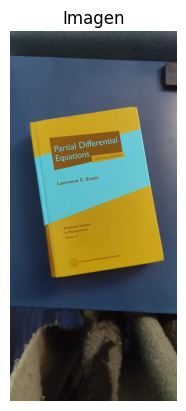

In [20]:
plt.imshow(img)
plt.title('Imagen')
plt.axis('off')
plt.show()

In [13]:
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(thresh, lang='spa', config=custom_config)

In [14]:
text

"SS A E ao! E o NIDOS\nNN ACES NS OS OS\nSEA E O OS\nA eS A ES:\ne NS RN\nE O O a ea (E\nA RNE An xo jey oo NE ad (E\nCAR O ER ON CN SIN A a] 2\na Lo, SE NE Dd o\nA E\nO DO cl a A\ne e E aa eN A\nA o ON A\ne NIN\ne a o o ros\nle adn li\nO\net a A\nTOA EOS DO A A\nON Vi E\no SN MESE\nE E Oda a WE ao\nA E AAN\nA | pr TA ON al E e\nDN A AN e o\nE NY ho Sd o ierena e,\nOS EA! Partia : . E md, : AN\nA EA EAU A O MION PR\nCS UE EQU pa . COS\nA O CU EN\na A VE A O\nA e Loa a a a RARE\nE UN UE yan5 e ES\nA A —iaprencs O EN COS . AS\nO IN E\nIt CN E A A, A SN , Po,\nEA 14 CS AAA AA SN\ne O AE VI mz E ESO AOS E\nA A O\nO Ñ A O OE OR TES\nA\nA y A A\nA di O et Mr\nAOS NN CONTO\nA A de e PA E A\nA MO AOS A O\nA y O ON A O\nA A A\nA Y E O O\nEA AN A E TA LA E\nA A e AE 00 O A MENOS\nAn Y) O EN ion pineda E E\nA o Io\nA A\nE AS CR ADD\nSON A a E\na E Nro . RA A\nA AS IT RAN ES\nO\nA o a A A ceo A\nA A A A A EN IE AS\ne o IEA, COS\nA A O E a A o Ros leido\ne E\nO ATA E IAE FP TR E ino\nAe TO OA ES DE

In [15]:
def detect_objects(image, net, classes, conf_threshold=0.5, nms_threshold=0.4):
    # Obtener las dimensiones de la imagen
    height, width, _ = image.shape

    # Transformar la imagen en un blob
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Obtener los nombres de las capas de la red
    layer_names = net.getLayerNames()
    # Obtener los nombres de las capas de salida
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    
    # Realizar la detección de objetos
    outputs = net.forward(output_layers)

    # Inicializar listas para almacenar los resultados de la detección
    boxes = []
    confidences = []
    class_ids = []

    # Procesar las salidas de la detección
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > conf_threshold:
                # Escalar las coordenadas de la caja delimitadora a las dimensiones de la imagen original
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Calcular las coordenadas de la esquina superior izquierda de la caja delimitadora
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # Agregar las coordenadas, confianza y clase a las listas correspondientes
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Aplicar la supresión no máxima para eliminar detecciones superpuestas
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # Inicializar listas para almacenar los resultados finales de la detección
    detected_objects = []
    detected_classes = []
    detected_confidences = []

    # Procesar las detecciones finales
    for i in indices:
        i = i[0]
        box = boxes[i]
        x, y, w, h = box
        class_id = class_ids[i]
        class_name = classes[class_id]
        confidence = confidences[i]

        # Agregar los resultados a las listas correspondientes
        detected_objects.append(box)
        detected_classes.append(class_name)
        detected_confidences.append(confidence)

    return detected_objects, detected_classes, detected_confidences


In [16]:
detected_objects, detected_classes, detected_confidences = detect_objects(img, net, classes)

In [17]:
detected_objects

[]

In [18]:
detected_classes

[]

In [19]:
detected_confidences

[]